In [3]:

import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sys, os
sys.path.append(os.path.abspath(".."))
import access_br_dwgd as access_br_dwgd
sys.path.append(os.path.abspath("../.."))
import utils.utils as util
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="../../biLstmBrDwgd.log", nome_classe="BiLstm BrDwgd")
logger.info("Iniciando script de previsão com BiLSTM BrDwgd(TensorFlow/Keras).")

2025-10-25 15:21:30,515 - BiLstm BrDwgd - INFO - Iniciando script de previsão com BiLSTM BrDwgd(TensorFlow/Keras).


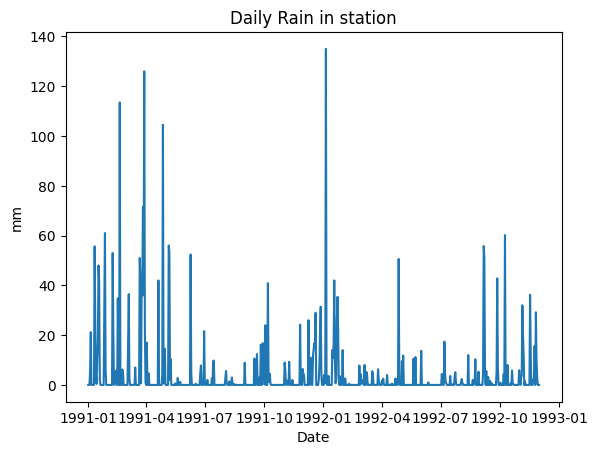

2025-10-25 15:22:44,044 - BiLstm BrDwgd - INFO - Dados carregados com sucesso. Total de 701 registros.


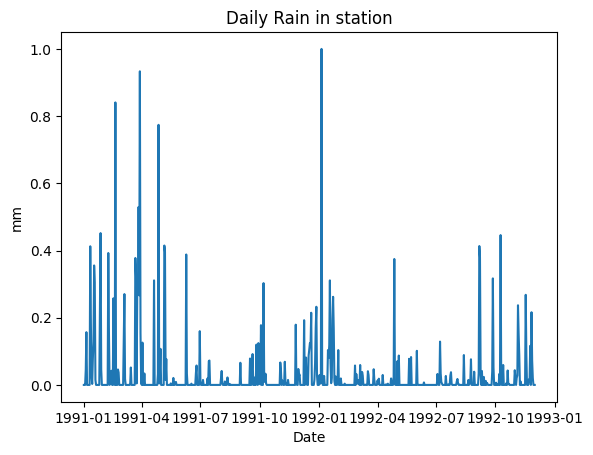

In [ ]:
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
#timeseries = timeseries.to_frame(name='chuva')
#timeseries['chuva'] = np.log1p(timeseries['chuva'])

num_features = 17
# 2. FEATURES TEMPORAIS
timeseries['dia_seno'] = np.sin(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['dia_cosseno'] = np.cos(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['mes_seno'] = np.sin(2 * np.pi * timeseries.index.month / 12)
timeseries['mes_cosseno'] = np.cos(2 * np.pi * timeseries.index.month / 12)

timeseries['chuva_ma3']  = timeseries['chuva'].shift(1).rolling(window=3, min_periods=1).mean().fillna(0)
timeseries['chuva_ma7']  = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).mean().fillna(0)
timeseries['chuva_ma14'] = timeseries['chuva'].shift(1).rolling(window=14, min_periods=1).mean().fillna(0)
timeseries['chuva_ma30'] = timeseries['chuva'].shift(1).rolling(window=30, min_periods=1).mean().fillna(0)

# 2. Estatísticas móveis
timeseries['chuva_std7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).std().fillna(0)
timeseries['chuva_max7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).max().fillna(0)
timeseries['chuva_min7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).min().fillna(0)

# 3. Lags
timeseries['chuva_lag1'] = timeseries['chuva'].shift(1).fillna(0)
timeseries['chuva_lag3'] = timeseries['chuva'].shift(3).fillna(0)
timeseries['chuva_lag7'] = timeseries['chuva'].shift(7).fillna(0)

# 5. Flags binários
timeseries['choveu_ontem'] = (timeseries['chuva_lag1'] > 0).astype(int)
timeseries['choveu_semana'] = (timeseries['chuva_ma7'] > 0).astype(int)

features_dinamicas = [col for col in timeseries.columns if 'chuva' in col]
features_sazonais = ['dia_seno', 'dia_cosseno', 'mes_seno', 'mes_cosseno']
scaler_chuva = MinMaxScaler()
timeseries[features_dinamicas] = scaler_chuva.fit_transform(timeseries[features_dinamicas])

logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 

plt.plot(timeseries['chuva'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

In [ ]:
lookback = 45
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequence(timeseries.values, lookback)
dates_aligned = datas[lookback:]

train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")
logger.info(f"Shape {X_train.shape}")


In [ ]:
epochs = 300
batch_size = 16
# Building the model

model = lstm.criar_modelo_avancado(
    lookback=lookback,
    n_features=num_features,
    units_camada1=128,
    units_camada2=64,
    dropout_rate=0.1,
    l2_kernel=0.01,
    l2_bias=0.01,
    learning_rate=0.001
    
)
logger.info(f"Iniciando treinamento por {epochs} épocas. Com batch_size: {batch_size}")


print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# patience=15: espera 30 épocas sem melhora antes de parar

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1)
# factor=0.2: reduz o learning rate para 20% do valor atual
# patience=5: espera 5 épocas sem melhora antes de reduzir
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ early_stopping, reduce_lr ]
)
logger.info("Treinamento concluído.")


In [ ]:
# --- Previsão ---
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)
print(pred)
n_features_chuva = scaler_chuva.n_features_in_
pred_dummy = np.zeros((len(pred), n_features_chuva))
pred_dummy[:, 0] = pred.flatten()
pred_log = scaler_chuva.inverse_transform(pred_dummy)[:, 0]
pred = np.expm1(pred_log)

y_test_dummy = np.zeros((len(y_test), n_features_chuva))
y_test_dummy[:, 0] = y_test.flatten()
y_testlog = scaler_chuva.inverse_transform(y_test_dummy )[:, 0]
y_test = np.expm1(y_testlog)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

In [ ]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")